In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division, print_function
from ipywidgets import interact, widgets
from IPython.display import display, HTML
import os
from PIL import Image
from scipy.io import savemat, loadmat
import warnings
warnings.filterwarnings("ignore")
matplotlib.style.use('ggplot')
#!jupyter nbextension enable --py widgetsnbextension

Populating the interactive namespace from numpy and matplotlib


# Summary
There is a clear need for simple and effective clinical biomarkers of airways disease. Mucus clearance and trapping of inhaled pathogens is the first line of immune defence. In human airways diseases, including cystic fibrosis (CF) and chronic obstructive pulmonary disease (COPD), immune defense is compromised and airways inflammation and infection often result. Passive microbead rheology can be used to determine both diffusive and viscoelastic properties of mucus harvested from human bronchial epithelial (HBE) cultures.

# The basic idea underlying microrheology
  - Micron sized synthetic beads are suspended in a visco elastic fluid
  - Record stochastic motion of beads with video microscopy
  - Track bead position through time for all beads in a given video
  - Analyze bead motion to uncover properties of visco elastic fluid

# Example video clip of 2$\mu m$ synthetic beads in salt water

In [2]:
HTML('<video width="640" height="480" controls autoplay loop src="60fps_0002.mp4">')

# Model #1: Brownian motion
$$ x(t+dt) = x(t) + \sqrt{2Ddt} N(0, 1).$$
where $N(0, 1)$ is a normal random variable with zeros mean and unit variance and $D$ is the particle diffusivity (units length$^2$/time).

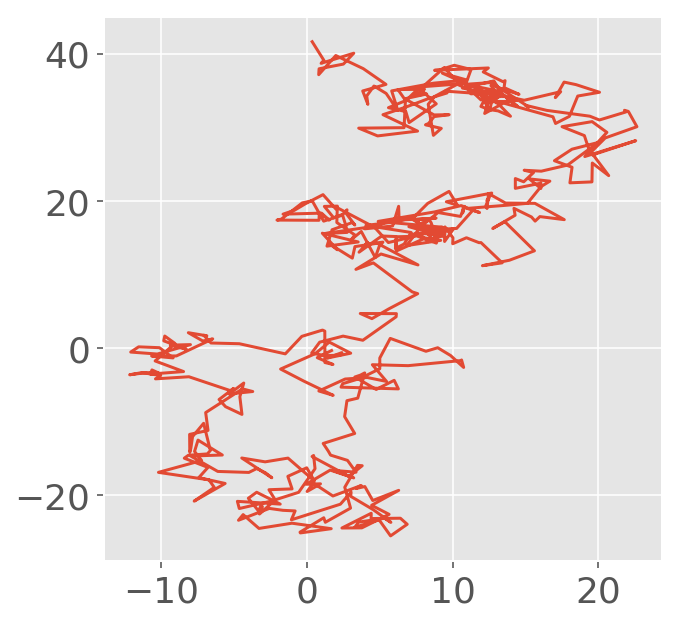

In [3]:
def BrownianPath(N, D=1., dt=1.):
    N = int(N)
    assert N > 1
    D = float64(D)
    assert D > 0
    dt = float64(dt)
    assert dt > 0
    q = sqrt(2*D*dt)
    un = q*normal(0, 1, (N, 2))
    sol = cumsum(un, axis=0)
    x, y = sol.T
    return x, y
x, y = BrownianPath(500)
matplotlib.rcParams.update({'font.size': 18}) # change default fontsize for plotting
figure(1, [5, 5])
plot(x, y);

# Model #2: Fractional Brownian motion (FBM)
$$ x(t+dt) = x(t) + \Delta x(t + dt) $$
$$ \Delta {\bf x} = {\bf N}(0, V)  $$
where ${\bf N}$ is a vector of correlated normal random variables with covariance matrix
$$V_{t, s} = \frac{1}{2}\left(t^{\alpha} + s^{\alpha} - |t - s|^{\alpha}\right)$$

In [4]:
def FBM(N, alpha=1., D=1., dt=1.):
    N = int(N)
    assert N > 1
    alpha = float64(alpha)
    assert 0 < alpha < 2
    D = float64(D)
    assert D > 0
    dt = float64(dt)
    assert dt > 0
    q = sqrt(2*D*dt)
    
    t = linspace(0, (N-1)*dt, N)
    T, S = meshgrid(t, t)
    V = 0.5*(T**alpha + S**alpha - absolute(T - S)**alpha)
    Lam, U = eig(V)
    ## define R = U*sqrt(Lam)*Uinv
    ## can check that R*R = V
    R = matmul(matmul(U, diag(sqrt(Lam))), matrix(U).I)
    un = q*normal(0, 1, (N, 2))
    sol = matmul(un.T, R).T
    return sol[:, 0], sol[:, 1]


@interact(alpha=(0., 1., 0.025))
def pfun(alpha=1.):
    fig = figure(1, [10, 5])
    x, y = FBM(500, alpha=alpha)
    plot(x, y, label='FBM');
    plot(0, 0, 'kx')
    xBM, yBM = BrownianPath(500)
    plot(100+xBM, yBM, label='Brownian motion');
    plot(100, 0, 'kx')
    xlabel('x')
    ylabel('y')
    xlim(-50, 150)
    ylim(-50, 50)
    legend(loc='upper center');

A Jupyter Widget

# Particle tracking data
## The first step is to import and preprocess a dataset

In [5]:
DataFiles = {
    'Agarose': [
        'Data/Agarose/Agarose.mat'],
    'HA': [
        'Data/HA/HA7.mat', 
        'Data/HA/HA10.mat'],
    'HBE Mucus': [
        'Data/HBE Mucus/HBE1p5',
        'Data/HBE Mucus/HBE2',
        'Data/HBE Mucus/HBE2p5',
        'Data/HBE Mucus/HBE3',
        'Data/HBE Mucus/HBE4',
        'Data/HBE Mucus/HBE5'],
    'Saltwater': [
        'Data/Saltwater/saltwater.mat']}

### time is in seconds and length is in microns
dt = 1/60.
dx = 0.12
def preprocess(data):
    data = data[[k for k in data.keys() if '__' not in k][0]]
    keys = data.dtype.names
    fieldsToExtract = {
        'FileName': 'FileNames', 
        'InitialPosition': 'InitialPositions', 
        'PathLength': 'PathLengths', 
        'Positions': 'Positions'}
    cleaned = {}
    for k, label in fieldsToExtract.iteritems():
        assert k in keys
        d = data[k].ravel()
        if k == 'Positions':
            starts = data['InitialPosition'].squeeze()
            tracks = []
            for n, track in enumerate(d):
                x0 = starts[n].squeeze().astype('float64')
                tracks.append(dx*(x0 + track.squeeze().astype('float64')))
            cleaned[label] = tracks
        else:
            cleaned[label] = array([dj.squeeze() for dj in d])
    cleaned['UniqueFileNames'] = unique(data['FileName'])
    return cleaned
##############################################
condition = 'HBE Mucus'
dataset = -1
dataRaw = loadmat(DataFiles[condition][dataset])
data = preprocess(dataRaw)

# Looking at all the tracks in a given video

In [6]:
Nfiles = data['UniqueFileNames'].size
@interact(fileNumber=(0, Nfiles-1, 1), magFactor=(1., 10., 0.25))
def plotfn(fileNumber=0, magFactor=1.):
    figure(1, [8, 8])
    fileName = data['UniqueFileNames'][fileNumber]
    tracks = []
    for track, name in zip(data['Positions'], data['FileNames']):
        if str(name) == fileName:
            tracks.append(track)
    for track in tracks:
        x0 = track[0]
        track = magFactor*(track - x0) + x0
        plot(track[:, 0], track[:, 1])
    xlim(xmin=-0.1)
    ylim(ymin=-0.1)
    xlabel('x')
    ylabel('y');
    title(fileName[0]);

A Jupyter Widget

In the figure above, notice there is an option to change 'magFactor'. Sometimes it is useful to visualize artificially stretched-out versions of the tracks. The 'magFactor' option keeps the relative starting positions of the tracks the same, while multiplying the displacements by 'magFactor'. The result can reveal patterns in the 'drift' that we might otherwise miss.

# Visualizing individual paths

In [7]:
Npaths = data['PathLengths'].size
@interact(trackNumber=(0, Npaths-1, 1))
def plotfn(trackNumber=0):
    track = data['Positions'][trackNumber].copy()
    track -= track[0]
    DXY = absolute(track[-1] - track[0])
    cutoff = 10.
    r = max(1/cutoff, min(cutoff, DXY[1]/DXY[0]))
    scale = max(2, min(10, 50*DXY.max()))
    if r > 1:
        figure(1, [scale/r, scale])
    else:
        figure(1, [scale, scale*r])
    grid()
    plot(track[:, 0], track[:, 1])
    plot(track[0, 0], track[0, 1], 'ko')
    xlabel('x')
    ylabel('y');

A Jupyter Widget

# Mean squared displacement analysis
The MSD is estimated with the formula
$$ MSD(\tau) = \frac{1}{T-\tau}\sum_{i=1}^{N - \tau/\Delta t}\Vert {\bf x}(t_i + \tau) - {\bf x}(t_i)\Vert^2 $$
where $\tau$ is called the 'time lag' (must be an integer multiple of $\Delta t$), $\Delta t$ is the duration of one track increment (inverse of video framerate), $N$ is the number of observations in the track, and $T = N\Delta t$ is the duration of the track.

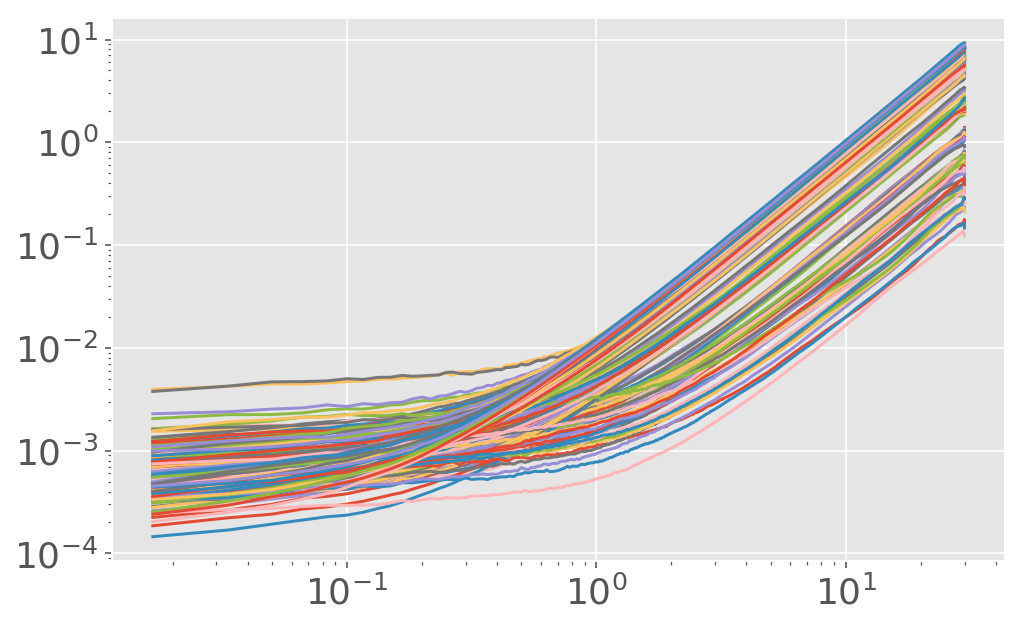

In [8]:
def MSD(track):
    #x, y = track[:, 0], track[:, 1]
    N, d = track.shape
    T = N*dt
    msd = zeros(N - 1)
    for n in arange(1, N):
        DXY = track[:N-n] - track[n:]
        tau = n*dt
        msd[n-1] = (DXY**2).sum()/(T - tau)
    return msd

fig = figure(1, [8, 5])
for track in data['Positions'][:]:
    msd = MSD(track)
    N = msd.size
    tau = linspace(dt, N*dt, N)
    loglog(tau, msd)

## Compute and plot the ensemble-averaged MSD
Note that you will have to figure out how to average MSDs from tracks that have different lengths.
The formula is
$$ \langle MSD(\tau) \rangle = \frac{1}{N_{tr}(\tau)}\sum_{i=1}^{N_{tr}(\tau)}MSD_i(\tau), $$
where $MSD_i(\cdot)$ is the MSD computed for the $i$th track and $N_{tr}(\tau)$ is the total number of tracks whose length is less than $\tau$.


## How is the ensemble-averaged MSD affected by 'drift' in the HA dataset?

## Can you correct for 'drift' in the MSD estimate?

## How does MSD change with weight-% for HBE Mucus?
Note that the HBE Mucus track data files correspond to 1.5%, 2%, 2.5%, 3%, 4%, and 5%. See also Fig. 2 in Hill et. al. PLOS One. 9:2 e87681 2014.